**Author**: J W Debelius<br/>
**Date**: 23 July 2015<br/>
**virtualenv**: power play

In [1]:
%%javascript
IPython.load_extensions('calico-spell-check', 'calico-document-tools')

<IPython.core.display.Javascript object>

The purpose of this notebook is to test the effect of outliers on traditional power calculations, on emperical power calculations, and on extrapolated power. 

This notebook will focus on using a Case I t test as a model for introducing outliers. We will test the alternative hypotheses that
<center><strong>H</strong><sub>0</sub>: $\bar{x} = 0$<br>
<strong>H</strong><sub>1</sub>: $\bar{x} \neq 0$</center>
for some sample with mean $\bar{x}$ and standard deviation, $s$, drawn from an underlying population with mean, $\mu$ ($\mu \neq 0$) and variance $\sigma^{2}$. 

In [3]:
from __future__ import division
import numpy as np
from absloute_power.traditional import calc_ttest_1

We can test these hypotheses using the scipy function `scipy.stats.ttest_1samp`.

In [4]:
import scipy.stats

def emp_ttest_1(samples):
    return scipy.stats.ttest_1samp(samples[0], 0)[1]

In the traditional model of power, the effect size for a sample given by
$\begin{align*}
\lambda &=\frac{(\bar{x} - x)}{s}\\
&= \frac{\bar{x}}{s}\\
&= \frac{t}{\sqrt{n}}
\end{align*}\tag{1}$

We may also choose to use the emperical power function developed in scikit-bio (`skbio.stats.power.subsample_power`). There are other explinations of the theory behind that function, so we're not going to give the formal defination here. Essentially, the function takes a statical test, and a sample or set of samples and uses Monte Carlo simulation to estimate the power.

The emperical power can then be used to extraplote a power using Statsmodels. This is not always effecient *Note: may want to look at expanding this*. 

In [7]:
from skbio.stats.power import subsample_power

import americangut.power_plots as pp
from statsmodels.stats.power import FTestAnovaPower

ft = FTestAnovaPower()

def extrapolate_f(counts, pwr_, cnts, alpha=0.05):
    """..."""
    # Gets the average emperical effect size
    eff_mean, eff_bound =  pp.collate_effect_size([cnts], [pwr_], alpha)
    # Calculates the extrapolated power curve
    extr_pwr = np.array([
            ft.solve_power(eff_mean, nobs=c, alpha=0.05, power=None)
            for c in counts
        ])
    return extr_pwr

[Explination of what we're actually doing here which will be written eventually]

We're going to compare the ability of the traditional post-hoc power, emperical post-hoc power and extrapolated post-hoc power to re-capiluate the traditional power calculation. We'll approach this by simuling a random population with a mean, $\mu$ and standard devation, $\sigma$, and then drawing a random sample of size $n$ with mean $\bar{x}$ and standard devation $s$.

In [8]:
def ttest_1_simulate(mu_lim, sigma_lim, count_lims):
    # Gets the distribution parameters
    mu = np.random.randint(*mu_lim)
    sigma = np.random.randint(*sigma_lim)
    n = np.random.randint(*count_lims)
    
    dist = mu + np.random.randn(n) * sigma

    # Draws a sample that fits the parameters
    return [mu, sigma, n], dist

We can design a function that will let us "spike in" outliers: points drawn from a distribution `offset` units above or below the central mean. 

In [9]:
def add_outliers(dist, num_out, offset=50):
    # Draws the offset mean
    if num_out > 0:
        index = np.arange(0, len(dist))
        # Selects the points ot be outliers
        outlier_pos = np.random.choice(np.arange(0, len(dist)), num_out, replace=False)
        # Updates the distribution
        dist[outlier_pos] = dist[outlier_pos] + offset
    
    return [num_out, offset], [dist]

We're going to use the function to simulate several distributions with varying numbers of outliers. We're going to draw distributions with means between 2 and 10, standard deviations between 5 and 15, and at 120 points.

In [11]:
mu_lims = [2, 10]
sigma_lims = [5, 15]
num_counts = 250
count_lims = [num_counts, num_counts+1]

We'll simulate the distributions so they have no outliers, 1%, 2%, 5%, 10% and 20% outliers. The offset mean can fall between -50 and 50 units offset from the original distribution.

In [17]:
num_outliers = (np.concatenate((np.array([0, 1]), np.array([0.01, 0.02, 0.05, 0.1, 0.2])*num_counts))).astype(int)
offset=100
# num_outliers

array([ 0,  1,  2,  5, 12, 25, 50])

When we draw traditional and emperical power, we'll do it starting at 5 samples up to 100 samples, counting by 5s. We draw 100 samples to calculate power for each point, and repeat this three times at each point along the curve. We'll use an alpha value of 0.05. And, we'll simulate 1000 distributions for each number of outliers.

In [18]:
counts = np.arange(10, 101, 10)
alpha=0.05
subsample_params = {'min_counts': 5,
                    'max_counts': 101,
                    'counts_interval': 5,
                    'num_runs': 3,
                    'num_iter': 100,
                    'alpha_pwr': alpha}
num_reps = 10

In [19]:
num_outliers

array([ 0,  1,  2,  5, 12, 25, 50])

Let's build the simulated populations.

In [26]:
dist

[array([ 27.06797231,  -6.20217624,  -1.28184088,  12.61754378,
          9.10833054,  -0.06285203,   8.52344716,  -3.00704012,
        -33.71774007, -25.09616009,  15.43119285, -10.98654342,
          7.50839559, -32.07086618,   5.69440833,  -9.76504705,
          0.96784892,  -9.29741784,   4.54865039,  -3.25059788,
          1.11108134, -16.01657285,   5.22788383,  -5.82633033,
         -6.30309695,  15.23057424,   5.83790037,   2.84492444,
        -14.22613421,   6.75386638,   5.32191896,  -2.50041851,
         10.87572959,  -0.04939776,  -3.37345545,  -2.02940865,
        -17.961425  ,   6.06709898,  -1.46216709,  13.09801649,
        -25.25047278,  30.62084466,  -2.61689613,  18.38404205,
         14.15318645,   3.03950817,   4.61826809,   0.2099581 ,
        -13.08684515,   1.91507982,   7.20059061,   5.74955609,
         -4.59961202,  -0.23986688,  -7.8948292 ,  -5.31716008,
         16.35343999,  -2.53314139,   6.20840998,   0.76358323,
         -9.21140002,   6.59081663,   5.

In [27]:
watch = {o: {'pop_params': [], 'sample_params': [], 'pop__power': [], 'base_power': [], 'samp_power': [], 
             'empr_power': [], 'extr_power': []} for o in num_outliers}
for o in num_outliers:
    v = watch[o]
    for i in xrange(num_reps):
        # Draws a sample distribution
        params, sample = ttest_1_simulate(mu_lims, sigma_lims, count_lims)
        calc_ttest_1(sample, x0=0, counts=counts)
        base_power = ttest1_power(base_eff, counts)
        # Spikes in outliers, if necessary
        (num_out, offset), dist = add_outliers(sample, o, offset)
        params.append(num_out)
        params.append(offset)
        # Calculates the effect using the tradtional method
        samp_power = calc_ttest_1(dist[0], 0, counts)
        #  Calculates the emperical power
        empr_power, empr_counts = subsample_power(emp_ttest_1,
                                                  dist,
                                                  **subsample_params)
        # Calculates the extraploted power
        extr_power = extrapolate_f(counts, empr_power, empr_counts).flatten()
        
        #Updates watch
        v['pop_params'].append(params)
        v['base_power'].append(base_power)
        v['samp_power'].append(samp_power)
        v['empr_power'].append(empr_power.mean(0))
        v['extr_power'].append(extr_power)
        
    v['base'] = np.concatenate(watch[o]['base_power'])
    v['samp'] = np.concatenate(watch[o]['samp_power'])
    v['empr'] = np.concatenate(v['empr_power'])
    v['extr'] = np.concatenate(v['extr_power'])
    v['exte'] = np.isnan(v['extr']) == False
    
    v['trad_reg'] = scipy.stats.linregress(v['base'], v['samp'])
    v['empr_reg'] = scipy.stats.linregress(v['base'], v['empr'])
    v['extr_reg'] = scipy.stats.linregress(v['base'][v['exte']], v['extr'][v['exte']])
    v['samp_empr'] = scipy.stats.linregress(v['samp'], v['empr'])
    v['samp_extr'] = scipy.stats.linregress(v['samp'][v['exte']], v['extr'][v['exte']])
    v['empr_extr'] = scipy.stats.linregress(v['empr'][v['exte']], v['extr'][v['exte']])
    watch[o] = v

ValueError: all the input array dimensions except for the concatenation axis must match exactly

Now that we have the populations, let's plot them to compare the power.

In [332]:
width/(2.5/0.9)

1.1300000000000001

In [333]:
import matplotlib.pyplot as plt
% matplotlib inline

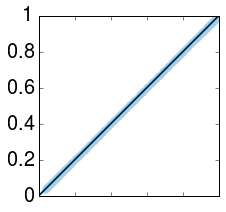

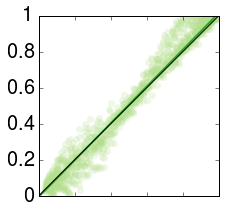

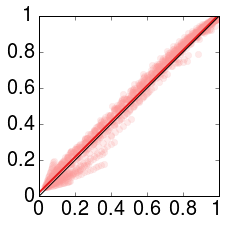

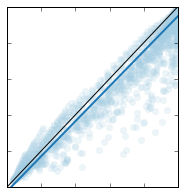

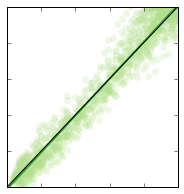

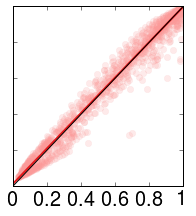

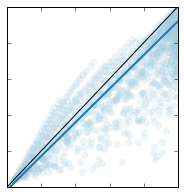

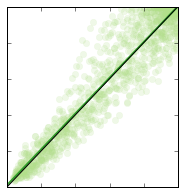

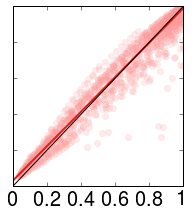

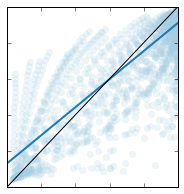

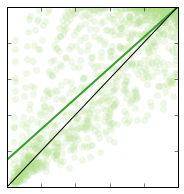

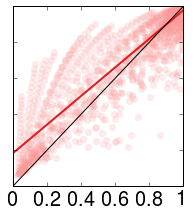

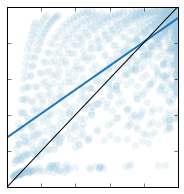

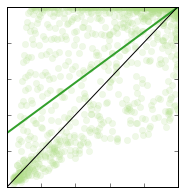

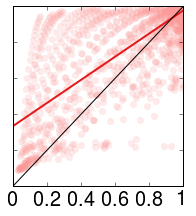

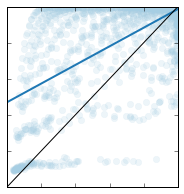

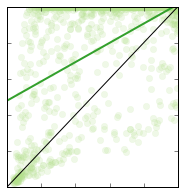

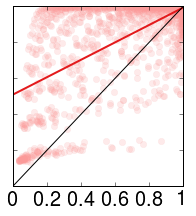

In [338]:
idx = np.arange(0, 1.1, 0.1)
data_summary = [('samp', 'trad_reg', '#a6cee3', '#1f78b4'), 
                ('empr', 'empr_reg', '#b2df8a', '#33a02c'), 
                ('extr', 'extr_reg', '#fb9a99', '#e31a1c')]
width = 2.5/0.9*0.95 + 0.5

for i, o in enumerate(num_outliers):
# for i, o in [(0, 1)]:
#     for draw, reg, color1, color2 in [('samp', 'trad_reg', '#a6cee3', '#1f78b4')]:
    for draw, reg, color1, color2 in data_summary:
        fn = '/Users/jwdebelius/Desktop/figure_test/outlier_summary/%s_%i.pdf' % (draw, o)
        # Draws the results
        v = watch[o]
        if d in {'extr'}:
            x = v['base'][v['exte']]
            y = v[draw][v['exte']]
        else:
            x = v['base']
            y = v[draw]
        m, b, r, p, s = v[reg] 
        
        # Creates the figure
        fig = plt.figure()
        fig.set_size_inches(2.5/0.95, 2.5/0.9)
        ax = fig.add_axes((0.05, 0.05, 0.9, 0.9))
        
        # Plots the scatter
        ax.plot(x, y, '.', alpha=0.2, mfc=color1, mec=color1, ms=12)
        ax.plot(idx, m*idx + b, color=color2, linewidth=2)
        ax.plot(idx, idx, 'k-')
        
        # Cleans up the axes
        ax.set_xlim([0, 1])
        ax.set_ylim([0, 1])
        
        ax.set_xticklabels('')
        ax.set_yticklabels('')
        
        if i == 0 and draw == 'extr':
            ax.set_xticklabels(['0', '0.2', '0.4', '0.6', '0.8', '1'], size=20)
            ax.set_yticklabels(['0', '0.2', '0.4', '0.6', '0.8', '1'], size=20)
            fig.set_size_inches((width, width))
            ax.set_position((0.5/width, 0.5/width, 2.5/width, 2.5/width))
        elif i == 0:
            ax.set_xticklabels('')
            ax.set_yticklabels(['0', '0.2', '0.4', '0.6', '0.8', '1'], size=20)
            fig.set_size_inches((width, 2.5/0.9))
            ax.set_position((0.5/width, 0.05, 2.5/width, 0.9))
        elif draw == 'extr':
            ax.set_xticklabels(['0', '0.2', '0.4', '0.6', '0.8', '1'], size=20)
            ax.set_yticklabels('')
            fig.set_size_inches(2.5/0.95, width)
            ax.set_position((0.05, 0.5/width, 0.9, 2.5/width))
        else:
            ax.set
        fig.savefig(fn)
        

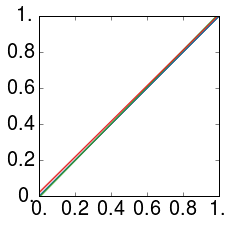

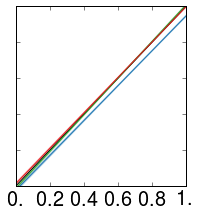

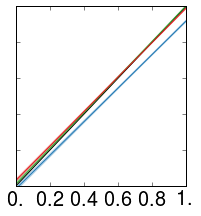

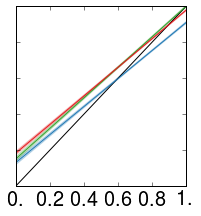

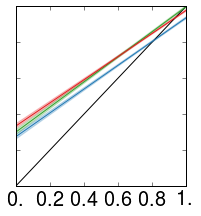

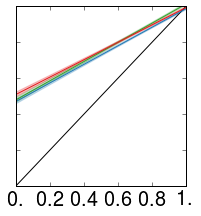

In [335]:
for i, o in enumerate(num_outliers):
    idx = np.arange(0, 1.01, 0.01)
    fig = plt.figure()
    fig.set_size_inches(2.5/0.95, width)
    ax = fig.add_axes((0.05, 0.5/width, 0.9, 2.5/width))
    ax.plot(idx, idx, 'k-')
    for draw, reg, color1, color2 in data_summary:
        fn = '/Users/jwdebelius/Desktop/figure_test/outlier_summary/comparison_%i.pdf' % o
        v = watch[o]
        if d in {'extr'}:
            x = v['base'][v['exte']]
            y = v[draw][v['exte']]
        else:
            x = v['base']
            y = v[draw]
        m, b, r, p, se = v[reg]
        n = len(x)
        
        xmin = np.min(x)
        xmax = np.max(x)
        xint = (xmax - xmin)/25
        p_x = np.arange(xmin-xint, xmax+2*xint, xint)
        
        t = scipy.stats.t.ppf(1 - 0.05/2, n - 2)
        mean_x = x.mean()
        
        conf = t * np.sqrt(
            se * (1./n + np.square(idx - mean_x)/(np.sum(np.square(x)) - n * np.square(mean_x)))
            )
        py = m * idx + b
        
        ax.fill_between(idx, py-conf, py+conf, alpha=0.25, color=color2)
        ax.plot(idx, py, color=color2)
        
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])

    if i > 0:
        ax.set_yticklabels('')
    else:
        ax.set_yticklabels(['0.', '0.2', '0.4', '0.6', '0.8', '1.'], size=20)
        fig.set_size_inches((width, width))
        ax.set_position((0.5/width, 0.5/width, 2.5/width, 2.5/width))
        
    ax.set_xticklabels(['0.', '0.2', '0.4', '0.6', '0.8', '1.'], size=20)
        
    fig.savefig(fn)

In [171]:
help(plt.plot)

Help on function plot in module matplotlib.pyplot:

plot(*args, **kwargs)
    Plot lines and/or markers to the
    :class:`~matplotlib.axes.Axes`.  *args* is a variable length
    argument, allowing for multiple *x*, *y* pairs with an
    optional format string.  For example, each of the following is
    legal::
    
        plot(x, y)        # plot x and y using default line style and color
        plot(x, y, 'bo')  # plot x and y using blue circle markers
        plot(y)           # plot y using x as index array 0..N-1
        plot(y, 'r+')     # ditto, but with red plusses
    
    If *x* and/or *y* is 2-dimensional, then the corresponding columns
    will be plotted.
    
    An arbitrary number of *x*, *y*, *fmt* groups can be
    specified, as in::
    
        a.plot(x1, y1, 'g^', x2, y2, 'g-')
    
    Return value is a list of lines that were added.
    
    By default, each line is assigned a different color specified by a
    'color cycle'.  To change this behavior, you can 

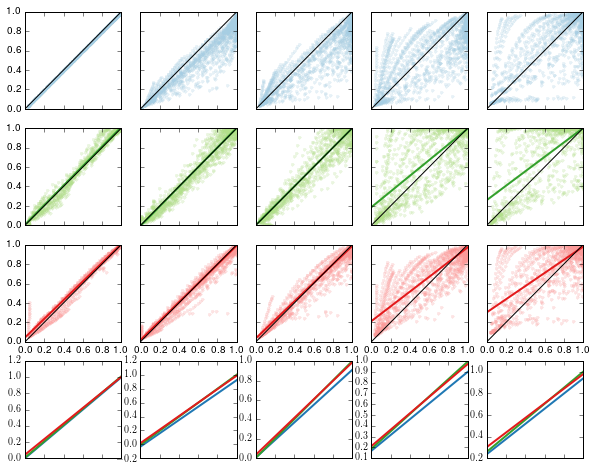

In [155]:
import matplotlib.pyplot as plt
% matplotlib inline

idx = np.arange(0, 1.1, 0.1)

for i, o in enumerate(num_outliers):
    
    v = watch[o]
    
    mt, bt, rt, pt, st = v['trad_reg']
    mm, bm, rm, pm, sm = v['empr_reg']
    mx, bx, rx, px, sx = v['extr_reg']
        
    ax1t = fig1.add_subplot(4, 5, i+1)
    ax1m = fig1.add_subplot(4, 5, i+6)
    ax1r = fig1.add_subplot(4, 5, i+11)
    ax1a = fig1.add_subplot(4, 5, i+16)
    

    ax1t.plot(v['base'], v['samp'], '.', alpha=0.25, color='#a6cee3')
    ax1m.plot(v['base'], v['empr'], '.', alpha=0.25, color='#b2df8a')
    ax1r.plot(v['base'], v['extr'], '.', alpha=0.25, color='#fb9a99')
    
    ax1m.plot(idx, mm*idx + bm, '-', color='#33a02c', linewidth=2)
    ax1r.plot(idx, mx*idx + bx, '-', color='#e31a1c', linewidth=2)
    
    ax1a.plot(idx, mt*idx + bt, '-', color='#1f78b4', linewidth=2)
    ax1a.plot(idx, mm*idx + bm, '-', color='#33a02c', linewidth=2)
    ax1a.plot(idx, mx*idx + bx, '-', color='#e31a1c', linewidth=2)
    
    
    
    ax1t.plot(idx, idx, 'k-')
    ax1m.plot(idx, idx, 'k-')
    ax1r.plot(idx, idx, 'k-')
    
    ax1t.set_xlim([0, 1])
    ax1m.set_xlim([0, 1])
    ax1r.set_xlim([0, 1])
    
    ax1t.set_ylim([0, 1])
    ax1m.set_ylim([0, 1])
    ax1r.set_ylim([0, 1])
    
    if i > 0:
        ax1t.set_yticklabels('')
        ax1m.set_yticklabels('')
        ax1r.set_yticklabels('')
    else:
        ax1t.set_yticklabels(ax1t.get_yticks())
        ax1m.set_yticklabels(ax1m.get_yticks())
        ax1r.set_yticklabels(ax1r.get_yticks())
    
    ax1t.set_xticklabels('')
    ax1m.set_xticklabels('')
    ax1a.set_xticklabels('')
    ax1r.set_xticklabels(['%1.1f' %t for t in ax1r.get_xticks()])
    
fig1.set_size_inches(10, 8)

In [151]:
def linear_confidence(x, y, xpred=None, alpha=0.05):
    """Calculates the confidence interval on the linear regression
    
    Based on Thomas Holderness's Blog and implementation
    (https://tomholderness.wordpress.com/2013/01/10/confidence_intervals/)
    
    """
    xmin = x.min()
    xmax = x.max()
    xint = (xmax - xmin)/10
    if xpred is None:
        xpred = np.arange(xmin-xint, xmax+2*xint, xint)
    
    # Fits the data to a regression model
    m, b, r, p, se = scipy.stats.linregress(x, y)
    
    
    # Calculates the confidence interval for the test data
    meanx = x.mean()
    n = len(x)
    t = scipy.stats.t.ppf(1-alpha/2, n-2)
    
    confs = t * np.sqrt((se/(n-2))*(1.0/n + (np.power((-mean_x),2)/
            ((np.sum(np.power(x,2)))-n*(np.power(mean_x,2))))))
    
    ypred = m * xpred + b
    
    return xpred, ypred, confs

In [144]:
help(scipy.stats.linregress)

Help on function linregress in module scipy.stats.stats:

linregress(x, y=None)
    Calculate a regression line
    
    This computes a least-squares regression for two sets of measurements.
    
    Parameters
    ----------
    x, y : array_like
        two sets of measurements.  Both arrays should have the same length.
        If only x is given (and y=None), then it must be a two-dimensional
        array where one dimension has length 2.  The two sets of measurements
        are then found by splitting the array along the length-2 dimension.
    
    Returns
    -------
    slope : float
        slope of the regression line
    intercept : float
        intercept of the regression line
    r-value : float
        correlation coefficient
    p-value : float
        two-sided p-value for a hypothesis test whose null hypothesis is
        that the slope is zero.
    stderr : float
        Standard error of the estimate
    
    
    Examples
    --------
    >>> from scipy import st

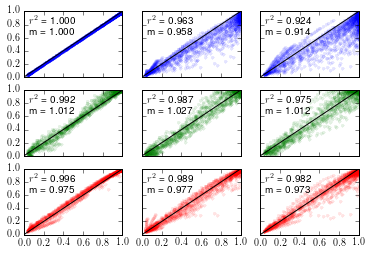

In [53]:

fig1 = plt.figure()
ax11 = fig1.add_subplot(3, 3, 1)
ax12 = fig1.add_subplot(3, 3, 2)
ax13 = fig1.add_subplot(3, 3, 3)
ax14 = fig1.add_subplot(3, 3, 4)
ax15 = fig1.add_subplot(3, 3, 5)
ax16 = fig1.add_subplot(3, 3, 6)
ax17 = fig1.add_subplot(3, 3, 7)
ax18 = fig1.add_subplot(3, 3, 8)
ax19 = fig1.add_subplot(3, 3, 9)
# Plots the traditional method with outliers
ax11.plot(np.concatenate(watch[0]['base_power']),
          np.concatenate(watch[0]['samp_power']), 'b.',
          alpha=0.1)
ax12.plot(np.concatenate(watch[1]['base_power']),
         np.concatenate(watch[1]['samp_power']), 'b.',
         alpha=0.1)
ax13.plot(np.concatenate(watch[2]['base_power']),
          np.concatenate(watch[2]['samp_power']), 'b.',
          alpha=0.1)
# Plots the emperical method without outliers
ax14.plot(np.concatenate(watch[0]['base_power']),
          np.concatenate(watch[0]['empr_power']), 'g.',
          alpha=0.1)
ax15.plot(np.concatenate(watch[1]['base_power']),
          np.concatenate(watch[1]['empr_power']), 'g.',
          alpha=0.1)
ax16.plot(np.concatenate(watch[2]['base_power']),
          np.concatenate(watch[2]['empr_power']), 'g.',
          alpha=0.1)

# Plots the extrapolated method without outliers
ax17.plot(np.concatenate(watch[0]['base_power']),
          np.concatenate(watch[0]['extr_power']), 'r.',
          alpha=0.1)
ax18.plot(np.concatenate(watch[1]['base_power']),
          np.concatenate(watch[1]['extr_power']), 'r.',
          alpha=0.1)
ax19.plot(np.concatenate(watch[2]['base_power']),
          np.concatenate(watch[2]['extr_power']), 'r.',
          alpha=0.1)

ax11.plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1), 'k-')
ax12.plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1), 'k-')
ax13.plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1), 'k-')

ax14.plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1), 'k-')
ax15.plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1), 'k-')
ax16.plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1), 'k-')

ax17.plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1), 'k-')
ax18.plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1), 'k-')
ax19.plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1), 'k-')

ax11.set_xticklabels('')
ax12.set_xticklabels('')
ax13.set_xticklabels('')
ax14.set_xticklabels('')
ax15.set_xticklabels('')
ax16.set_xticklabels('')
ax12.set_yticklabels('')
ax13.set_yticklabels('')
ax15.set_yticklabels('')
ax16.set_yticklabels('')
ax18.set_yticklabels('')
ax19.set_yticklabels('')

m11, b11, r11, p11, s11 = scipy.stats.linregress(np.concatenate(watch[0]['base_power']),
                                                 np.concatenate(watch[0]['samp_power']))
m12, b13, r12, p12, s12 = scipy.stats.linregress(np.concatenate(watch[1]['base_power']),
                                                 np.concatenate(watch[1]['samp_power']))
m13, b13, r13, p13, s13 = scipy.stats.linregress(np.concatenate(watch[2]['base_power']),
                                                 np.concatenate(watch[2]['samp_power']))
m14, b14, r14, p14, s14 = scipy.stats.linregress(np.concatenate(watch[0]['base_power']),
                                                 np.concatenate(watch[0]['empr_power']))
m15, b15, r15, p15, s15 = scipy.stats.linregress(np.concatenate(watch[1]['base_power']),
                                                 np.concatenate(watch[1]['empr_power']))
m16, b16, r16, p16, s16 = scipy.stats.linregress(np.concatenate(watch[2]['base_power']),
                                                 np.concatenate(watch[2]['empr_power']))
m17, b17, r17, p17, s17 = scipy.stats.linregress(np.concatenate(watch[0]['base_power'])[np.isnan(np.concatenate(watch[0]['extr_power'])) == False],
                                                 np.concatenate(watch[0]['extr_power'])[np.isnan(np.concatenate(watch[0]['extr_power'])) == False])
m18, b18, r18, p18, s18 = scipy.stats.linregress(np.concatenate(watch[1]['base_power'])[np.isnan(np.concatenate(watch[1]['extr_power'])) == False],
                                                 np.concatenate(watch[1]['extr_power'])[np.isnan(np.concatenate(watch[1]['extr_power'])) == False])
m19, b19, r19, p19, s19 = scipy.stats.linregress(np.concatenate(watch[2]['base_power'])[np.isnan(np.concatenate(watch[2]['extr_power'])) == False],
                                                 np.concatenate(watch[2]['extr_power'])[np.isnan(np.concatenate(watch[2]['extr_power'])) == False])
# print '$r^{2}$ = %1.1f \nm = %1.1f' % (r11, m11)
ax11.text(0.05, 0.65, '$r^{2}$ = %1.3f \nm = %1.3f' % (r11, m11), ha='left')
ax12.text(0.05, 0.65, '$r^{2}$ = %1.3f \nm = %1.3f' % (r12, m12), ha='left')
ax13.text(0.05, 0.65, '$r^{2}$ = %1.3f \nm = %1.3f' % (r13, m13), ha='left')
ax14.text(0.05, 0.65, '$r^{2}$ = %1.3f \nm = %1.3f' % (r14, m14), ha='left')
ax15.text(0.05, 0.65, '$r^{2}$ = %1.3f \nm = %1.3f' % (r15, m15), ha='left')
ax16.text(0.05, 0.65, '$r^{2}$ = %1.3f \nm = %1.3f' % (r16, m16), ha='left')
ax17.text(0.05, 0.65, '$r^{2}$ = %1.3f \nm = %1.3f' % (r17, m17), ha='left')
ax18.text(0.05, 0.65, '$r^{2}$ = %1.3f \nm = %1.3f' % (r18, m18), ha='left')
ax19.text(0.05, 0.65, '$r^{2}$ = %1.3f \nm = %1.3f' % (r19, m19), ha='left')

In [79]:
print v['base_power']
print v['samp_power']

[array([ 0.10953463,  0.351038  ,  0.55547342,  0.70483041,  0.80843196,
        0.87793177,  0.92339901,  0.95255459,  0.97094415,  0.98238234,
        0.98941183,  0.99368681,  0.99626263,  0.99780187,  0.99871485,
        0.99925274,  0.99956769,  0.99975107,  0.99985729,  0.99991852]), array([ 0.03118266,  0.04069855,  0.04864331,  0.05581848,  0.06255956,
        0.06902767,  0.07531171,  0.08146565,  0.08752446,  0.09351197,
        0.099445  ,  0.10533573,  0.11119316,  0.11702406,  0.12283358,
        0.12862562,  0.1344032 ,  0.14016862,  0.14592361,  0.1516695 ]), array([ 0.28869341,  0.77995752,  0.93569365,  0.98169454,  0.99491859,
        0.99862024,  0.9996324 ,  0.99990366,  0.99997511,  0.99999365,
        0.9999984 ,  0.9999996 ,  0.9999999 ,  0.99999998,  0.99999999,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ]), array([ 0.1610319 ,  0.52630288,  0.75497863,  0.877952  ,  0.94086705,
        0.97197955,  0.98696509,  0.9940304 ,  0.99730275

[]

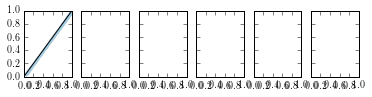

In [70]:
fig2 = plt.figure()

ax201 = fig2.add_subplot(3, 6, 1)
ax202 = fig2.add_subplot(3, 6, 2)
ax203 = fig2.add_subplot(3, 6, 3)
ax204 = fig2.add_subplot(3, 6, 4)
ax205 = fig2.add_subplot(3, 6, 5)
ax206 = fig2.add_subplot(3, 6, 6)

ax201.plot(np.concatenate(watch[0]['base_power']),
           np.concatenate(watch[0]['samp_power']), '.',
           color='#a6cee3', alpha=0.05)
# ax202.plot(np.concatenate(watch[1]['base_power']),
#            np.concatenate(watch[1]['samp_power']), '.',
#            alpha=0.05)
# ax203.plot(np.concatenate(watch[2]['base_power']),
#            np.concatenate(watch[2]['samp_power']), '.',
#            alpha=0.05)
# ax204.plot(np.concatenate(watch[6]['base_power']),
#            np.concatenate(watch[6]['samp_power']), '.',
#            alpha=0.05)
# ax205.plot(np.concatenate(watch[12]['base_power']),
#            np.concatenate(watch[12]['samp_power']), '.',
#            alpha=0.05)
# ax206.plot(np.concatenate(watch[24]['base_power']),
#            np.concatenate(watch[24]['samp_power']), '.',
#            alpha=0.05)
ax201.plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1), 'k-')
ax201.plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1), '-', color='#1f78b4')

ax202.set_yticklabels('')
ax203.set_yticklabels('')
ax204.set_yticklabels('')
ax205.set_yticklabels('')
ax206.set_yticklabels('')

[]

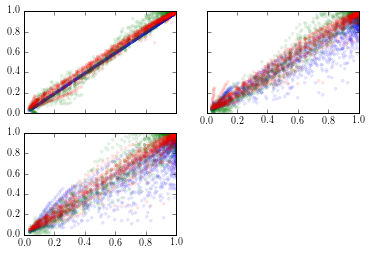

In [47]:
fig2 = plt.figure()
ax21 = fig2.add_subplot(2, 2, 1)
ax22 = fig2.add_subplot(2, 2, 2)
ax23 = fig2.add_subplot(2, 2, 3)

ax21.plot(np.concatenate(watch[0]['base_power']),
          np.concatenate(watch[0]['samp_power']), 'b.',
          alpha=0.1)
ax21.plot(np.concatenate(watch[0]['base_power']),
          np.concatenate(watch[0]['empr_power']), 'g.',
          alpha=0.1)
ax21.plot(np.concatenate(watch[0]['base_power']),
          np.concatenate(watch[0]['extr_power']), 'r.',
          alpha=0.1)

ax22.plot(np.concatenate(watch[1]['base_power']),
          np.concatenate(watch[1]['samp_power']), 'b.',
          alpha=0.1)
ax22.plot(np.concatenate(watch[1]['base_power']),
          np.concatenate(watch[1]['empr_power']), 'g.',
          alpha=0.1)
ax22.plot(np.concatenate(watch[1]['base_power']),
          np.concatenate(watch[1]['extr_power']), 'r.',
          alpha=0.1)

ax23.plot(np.concatenate(watch[2]['base_power']),
          np.concatenate(watch[2]['samp_power']), 'b.',
          alpha=0.1)
ax23.plot(np.concatenate(watch[2]['base_power']),
          np.concatenate(watch[2]['empr_power']), 'g.',
          alpha=0.1)
ax23.plot(np.concatenate(watch[2]['base_power']),
          np.concatenate(watch[2]['extr_power']), 'r.',
          alpha=0.1)

ax21.set_xticklabels('')
ax22.set_yticklabels('')

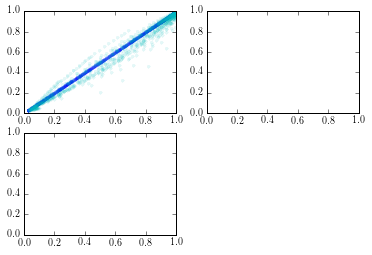

In [128]:
fig3 = plt.figure()
ax31 = fig3.add_subplot(2, 2, 1)
ax32 = fig3.add_subplot(2, 2, 2)
ax33 = fig3.add_subplot(2, 2, 3)

ax31.plot(np.concatenate(watch[0]['base_power']),
          np.concatenate(watch[0]['samp_power']), '.',
          alpha=0.1)
ax31.plot(np.concatenate(watch[1]['base_power']),
          np.concatenate(watch[1]['samp_power']), 'c.',
          alpha=0.1)
# ax31.plot(np.concatenate(watch[2]['base_power']),
#           np.concatenate(watch[2]['samp_power']), 'o',
#           alpha=0.1)

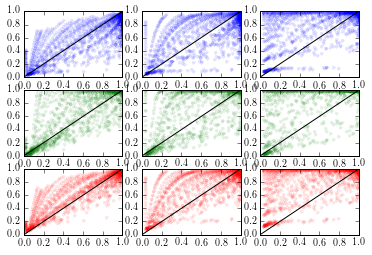

In [54]:
import matplotlib.pyplot as plt
% matplotlib inline
fig2 = plt.figure()
ax21 = fig2.add_subplot(3, 3, 1)
ax22 = fig2.add_subplot(3, 3, 2)
ax23 = fig2.add_subplot(3, 3, 3)
ax24 = fig2.add_subplot(3, 3, 4)
ax25 = fig2.add_subplot(3, 3, 5)
ax26 = fig2.add_subplot(3, 3, 6)
ax27 = fig2.add_subplot(3, 3, 7)
ax28 = fig2.add_subplot(3, 3, 8)
ax29 = fig2.add_subplot(3, 3, 9)
# Plots the traditional method with outliers
ax21.plot(np.concatenate(watch[6]['base_power']),
          np.concatenate(watch[6]['samp_power']), 'b.',
          alpha=0.1)
ax22.plot(np.concatenate(watch[12]['base_power']),
         np.concatenate(watch[12]['samp_power']), 'b.',
         alpha=0.1)
ax23.plot(np.concatenate(watch[24]['base_power']),
          np.concatenate(watch[24]['samp_power']), 'b.',
          alpha=0.1)
# Plots the emperical method without outliers
ax24.plot(np.concatenate(watch[6]['base_power']),
          np.concatenate(watch[6]['empr_power']), 'g.',
          alpha=0.1)
ax25.plot(np.concatenate(watch[12]['base_power']),
          np.concatenate(watch[12]['empr_power']), 'g.',
          alpha=0.1)
ax26.plot(np.concatenate(watch[24]['base_power']),
          np.concatenate(watch[24]['empr_power']), 'g.',
          alpha=0.1)

# Plots the extrapolated method without outliers
ax27.plot(np.concatenate(watch[6]['base_power']),
          np.concatenate(watch[6]['extr_power']), 'r.',
          alpha=0.1)
ax28.plot(np.concatenate(watch[12]['base_power']),
          np.concatenate(watch[12]['extr_power']), 'r.',
          alpha=0.1)
ax29.plot(np.concatenate(watch[24]['base_power']),
          np.concatenate(watch[24]['extr_power']), 'r.',
          alpha=0.1)

ax21.plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1), 'k-')
ax22.plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1), 'k-')
ax23.plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1), 'k-')

ax24.plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1), 'k-')
ax25.plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1), 'k-')
ax26.plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1), 'k-')

ax27.plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1), 'k-')
ax28.plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1), 'k-')
ax29.plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1), 'k-')

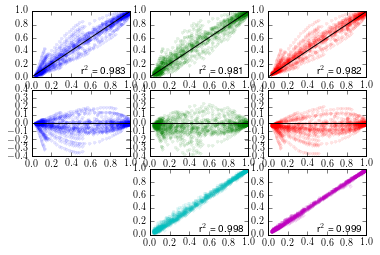

In [184]:
fig = plt.figure()
ax1 = fig.add_subplot(3, 3, 1)
ax2 = fig.add_subplot(3, 3, 2)
ax3 = fig.add_subplot(3, 3, 3)
ax1.plot(np.concatenate(watch['pop__power']), 
         np.concatenate(watch['samp_power']), 'b.', alpha=0.1)
ax2.plot(np.concatenate(watch['pop__power']), 
         np.concatenate(watch['empr_power']), 'g.', alpha=0.1)
ax3.plot(np.concatenate(watch['pop__power']),
         np.concatenate(watch['extr_power']), 'r.', alpha=0.1)
ax1.plot(np.arange(0, 1.1, .1), np.arange(0, 1.1, .1), 'k-')
ax2.plot(np.arange(0, 1.1, .1), np.arange(0, 1.1, .1), 'k-')
ax3.plot(np.arange(0, 1.1, .1), np.arange(0, 1.1, .1), 'k-')
r21, p = scipy.stats.pearsonr(np.concatenate(watch['pop__power']),
                              np.concatenate(watch['samp_power']))
r22, p = scipy.stats.pearsonr(np.concatenate(watch['pop__power']),
                              np.concatenate(watch['empr_power']))
r23, p = scipy.stats.pearsonr(np.concatenate(watch['pop__power'])[np.isnan(np.concatenate(watch['extr_power'])) == False],
                              np.concatenate(watch['extr_power'])[np.isnan(np.concatenate(watch['extr_power'])) == False])
ax1.text(0.95, 0.05, 'r$^2$ = %1.3f' % r21, ha='right')
ax2.text(0.95, 0.05, 'r$^2$ = %1.3f' % r22, ha='right')
ax3.text(0.95, 0.05, 'r$^2$ = %1.3f' % r23, ha='right')


ax4 = fig.add_subplot(3, 3, 4)
ax5 = fig.add_subplot(3, 3, 5)
ax6 = fig.add_subplot(3, 3, 6)

ax4.plot(np.concatenate(watch['pop__power']),
         np.concatenate(watch['pop__power']) - np.concatenate(watch['samp_power']),
         'b.', alpha=0.1)
ax5.plot(np.concatenate(watch['pop__power']),
         np.concatenate(watch['pop__power']) - np.concatenate(watch['empr_power']),
         'g.', alpha=0.1)
ax6.plot(np.concatenate(watch['pop__power']),
         np.concatenate(watch['pop__power']) - np.concatenate(watch['extr_power']),
         'r.', alpha=0.1)
ax4.plot(np.arange(0, 1.1, .1), 0*np.arange(0, 1.1, .1), 'k-')
ax5.plot(np.arange(0, 1.1, .1), 0*np.arange(0, 1.1, .1), 'k-')
ax6.plot(np.arange(0, 1.1, .1), 0*np.arange(0, 1.1, .1), 'k-')
ax4.set_ylim([-0.4, 0.4])
ax5.set_ylim([-0.4, 0.4])
ax6.set_ylim([-0.4, 0.4])

ax8 = fig.add_subplot(3, 3, 8)
ax9 = fig.add_subplot(3, 3, 9)

ax8.plot(np.concatenate(watch['samp_power']), np.concatenate(watch['empr_power']), 'c.', alpha=0.1)
ax9.plot(np.concatenate(watch['samp_power']), np.concatenate(watch['extr_power']), 'm.', alpha=0.1)
r28, p = scipy.stats.pearsonr(np.concatenate(watch['samp_power']),
                              np.concatenate(watch['empr_power']))
r29, p = scipy.stats.pearsonr(np.concatenate(watch['samp_power'])[np.isnan(np.concatenate(watch['extr_power'])) == False],
                              np.concatenate(watch['extr_power'])[np.isnan(np.concatenate(watch['extr_power'])) == False])
ax8.text(0.95, 0.05, 'r$^2$ = %1.3f' % r28, ha='right')
ax9.text(0.95, 0.05, 'r$^2$ = %1.3f' % r29, ha='right')

Now, let's try making 10% of the samples outliers

In [181]:
watch5 = {'pop_params': [],
         'sample_params': [],
         'pop__power': [],
         'samp_power': [],
         'empr_power': [],
         'extr_power': []}
for i in xrange(100):
    # Draws a sample distribution
    params, sample = ttest_1_simulate([1, 10], [5, 15], [500, 501], num_outliers=25)
    # Gets the distribution effect
    xp, sp, pn, no = params
    dist_eff = ttest1_eff(xp, sp)
    xs, ss, ns = get_vitals(*sample)
    samp_eff = ttest1_eff(xs, ss)
    # Calculates the power for the population
    counts = np.arange(5, 101, 5)
    dist_power = ttest1_power(dist_eff, counts)
    samp_power = ttest1_power(samp_eff, counts)

    # Calculates the emperical power
    empr_power, empr_counts = subsample_power(emp_ttest_1,
                                              sample,
                                              min_counts=5,
                                              max_counts=101,
                                              counts_interval=5,
                                              num_runs=3,
                                              num_iter=100)
    # Calculates the extraploted power
    extr_power = extrapolate_f(counts, empr_power, empr_counts).flatten()

    watch5['pop_params'].append((xp, sp, pn, dist_eff))
    watch5['sample_params'].append((xs, ss, ns, samp_eff))
    watch5['pop__power'].append(dist_power)
    watch5['samp_power'].append(samp_power)
    watch5['empr_power'].append(empr_power.mean(0))
    watch5['extr_power'].append(extr_power)

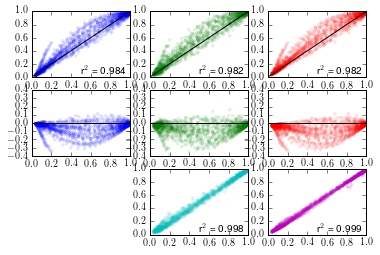

In [185]:
fig = plt.figure()
ax1 = fig.add_subplot(3, 3, 1)
ax2 = fig.add_subplot(3, 3, 2)
ax3 = fig.add_subplot(3, 3, 3)
ax1.plot(np.concatenate(watch5['pop__power']), 
         np.concatenate(watch5['samp_power']), 'b.', alpha=0.1)
ax2.plot(np.concatenate(watch5['pop__power']), 
         np.concatenate(watch5['empr_power']), 'g.', alpha=0.1)
ax3.plot(np.concatenate(watch5['pop__power']),
         np.concatenate(watch5['extr_power']), 'r.', alpha=0.1)
ax1.plot(np.arange(0, 1.1, .1), np.arange(0, 1.1, .1), 'k-')
ax2.plot(np.arange(0, 1.1, .1), np.arange(0, 1.1, .1), 'k-')
ax3.plot(np.arange(0, 1.1, .1), np.arange(0, 1.1, .1), 'k-')
r21, p = scipy.stats.pearsonr(np.concatenate(watch5['pop__power']),
                              np.concatenate(watch5['samp_power']))
r22, p = scipy.stats.pearsonr(np.concatenate(watch5['pop__power']),
                              np.concatenate(watch5['empr_power']))
r23, p = scipy.stats.pearsonr(np.concatenate(watch5['pop__power'])[np.isnan(np.concatenate(watch5['extr_power'])) == False],
                              np.concatenate(watch5['extr_power'])[np.isnan(np.concatenate(watch5['extr_power'])) == False])
ax1.text(0.95, 0.05, 'r$^2$ = %1.3f' % r21, ha='right')
ax2.text(0.95, 0.05, 'r$^2$ = %1.3f' % r22, ha='right')
ax3.text(0.95, 0.05, 'r$^2$ = %1.3f' % r23, ha='right')


ax4 = fig.add_subplot(3, 3, 4)
ax5 = fig.add_subplot(3, 3, 5)
ax6 = fig.add_subplot(3, 3, 6)

ax4.plot(np.concatenate(watch5['pop__power']),
         np.concatenate(watch5['pop__power']) - np.concatenate(watch5['samp_power']),
         'b.', alpha=0.1)
ax5.plot(np.concatenate(watch5['pop__power']),
         np.concatenate(watch5['pop__power']) - np.concatenate(watch5['empr_power']),
         'g.', alpha=0.1)
ax6.plot(np.concatenate(watch5['pop__power']),
         np.concatenate(watch5['pop__power']) - np.concatenate(watch5['extr_power']),
         'r.', alpha=0.1)
ax4.plot(np.arange(0, 1.1, .1), 0*np.arange(0, 1.1, .1), 'k-')
ax5.plot(np.arange(0, 1.1, .1), 0*np.arange(0, 1.1, .1), 'k-')
ax6.plot(np.arange(0, 1.1, .1), 0*np.arange(0, 1.1, .1), 'k-')
ax4.set_ylim([-0.4, 0.4])
ax5.set_ylim([-0.4, 0.4])
ax6.set_ylim([-0.4, 0.4])

ax8 = fig.add_subplot(3, 3, 8)
ax9 = fig.add_subplot(3, 3, 9)

ax8.plot(np.concatenate(watch5['samp_power']), np.concatenate(watch5['empr_power']), 'c.', alpha=0.1)
ax9.plot(np.concatenate(watch5['samp_power']), np.concatenate(watch5['extr_power']), 'm.', alpha=0.1)
r28, p = scipy.stats.pearsonr(np.concatenate(watch5['samp_power']),
                              np.concatenate(watch5['empr_power']))
r29, p = scipy.stats.pearsonr(np.concatenate(watch5['samp_power'])[np.isnan(np.concatenate(watch5['extr_power'])) == False],
                              np.concatenate(watch5['extr_power'])[np.isnan(np.concatenate(watch5['extr_power'])) == False])
ax8.text(0.95, 0.05, 'r$^2$ = %1.3f' % r28, ha='right')
ax9.text(0.95, 0.05, 'r$^2$ = %1.3f' % r29, ha='right')

In [186]:
watch10 = {'pop_params': [],
         'sample_params': [],
         'pop__power': [],
         'samp_power': [],
         'empr_power': [],
         'extr_power': []}
for i in xrange(100):
    # Draws a sample distribution
    params, sample = ttest_1_simulate([1, 10], [5, 15], [500, 501], num_outliers=50)
    # Gets the distribution effect
    xp, sp, pn, no = params
    dist_eff = ttest1_eff(xp, sp)
    xs, ss, ns = get_vitals(*sample)
    samp_eff = ttest1_eff(xs, ss)
    # Calculates the power for the population
    counts = np.arange(5, 101, 5)
    dist_power = ttest1_power(dist_eff, counts)
    samp_power = ttest1_power(samp_eff, counts)

    # Calculates the emperical power
    empr_power, empr_counts = subsample_power(emp_ttest_1,
                                              sample,
                                              min_counts=5,
                                              max_counts=101,
                                              counts_interval=5,
                                              num_runs=3,
                                              num_iter=100)
    # Calculates the extraploted power
    extr_power = extrapolate_f(counts, empr_power, empr_counts).flatten()

    watch10['pop_params'].append((xp, sp, pn, dist_eff))
    watch10['sample_params'].append((xs, ss, ns, samp_eff))
    watch10['pop__power'].append(dist_power)
    watch10['samp_power'].append(samp_power)
    watch10['empr_power'].append(empr_power.mean(0))
    watch10['extr_power'].append(extr_power)